# Exercise with A/B Testing

### Prompt

Let’s imagine you work on the For You Page at TikTok. Your team decides that instead of a heart button, they want to change it to star hoping that it will lead to a higher engagement/like rate. The product manager told you that the current conversion rate is about 6% on average throughout the year, and that the team would be happy with an increase of 3%, meaning that the new design will be considered a success if it raises the engagement rate to 9%.

Before rolling out the change, the team would be more comfortable testing it on a small number of users to see how it performs, so you suggest running an A/B test on a subset of the user base users.

In [1]:
# Packages imports
import numpy as np
import pandas as pd

# probability distributions & statistical functions
import scipy.stats as stats
# estimating statistical models
import statsmodels.stats.api as sms

import matplotlib.pyplot as plt
import seaborn as sns

#rounding function
from math import ceil



### Sample Size Calculation

In [2]:
# Calculate effect size based on our expected rates
eff_size = sms.proportion_effectsize(.06,.09)
eff_size

-0.11445118168989954

In [3]:
# Calculate sample size needed
req_size = sms.NormalIndPower().solve_power(
    eff_size, power = 0.8, alpha = 0.05, ratio = 1
)

req_size = ceil(req_size)
req_size

1199

### Collecting and preparing the data

In [4]:
# Load the tiktok_data.csv into a dataframe
df = pd.read_csv("tiktok_data.csv")
df.head()

,user_id,timestamp,group,button,liked
0,767017,2017-01-12 22:58:15,control,star,0
1,793849,2017-01-23 22:36:11,treatment,star,0
2,905617,2017-01-20 14:12:19,treatment,star,0
3,746742,2017-01-23 11:38:30,control,heart,0
4,892356,2017-01-05 9:35:15,treatment,star,1


In [5]:
# Get the info of the dataframe
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275781 entries, 0 to 275780
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    275781 non-null  int64 
 1   timestamp  275781 non-null  object
 2   group      275781 non-null  object
 3   button     275781 non-null  object
 4   liked      275781 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 10.5+ MB


In [6]:
# Make sure all the control group are seeing the star button and viceversa
pd.crosstab(df['group'], df['button'])

button,heart,star
group,,
control,136002,1816
treatment,1855,136108


In [7]:
# Check that no users have been sampled multiple times 
user_count = df['user_id'].value_counts()
print(user_count)
count_duplicate_id = user_count[user_count > 1].count()
count_duplicate_id

675062    2
770869    2
756732    2
839506    2
734187    2
         ..
902893    1
909038    1
906991    1
863984    1
630732    1
Name: user_id, Length: 272328, dtype: int64


3453

In [8]:
# If there are users who have been sampled multiple times, remove them from the dataframe

id_drop = user_count[user_count > 1].index
df = df[~df['user_id'].isin(id_drop)] #binary, says to not include the ones duplicated
print(df.shape[0])

user_count = df['user_id'].value_counts()
count_duplicate_id = user_count[user_count > 1].count()
count_duplicate_id

268875


0

#### Now that our DataFrame is nice and clean, we can proceed and sample n=4720 entries for each of the groups. We can use pandas' DataFrame.sample() method to do this, which will perform Simple Random Sampling for us.

In [9]:
# Perform simple random sampling to split the data into control and treatment

#I think for this case, minimum sample size is 1199, n=4270 was for lecture
control = df[df['group'] == 'control'].sample(n=req_size, random_state=111821)
treatment = df[df['group'] == 'treatment'].sample(n=req_size, random_state=111821)

In [10]:
# Create one table called ab_test that has both the cleaned control and treatment data
ab_test = pd.concat([control, treatment], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

,user_id,timestamp,group,button,liked
0,673554,2017-01-19 21:42:49,control,heart,0
1,704113,2017-01-20 0:17:01,control,heart,0
2,683594,2017-01-06 15:57:55,control,heart,0
3,737187,2017-01-10 4:03:45,control,heart,0
4,697525,2017-01-20 13:09:46,control,heart,0
...,...,...,...,...,...
2393,868104,2017-01-24 12:24:51,treatment,star,0
2394,703546,2017-01-21 3:18:07,treatment,star,0
2395,873991,2017-01-21 12:00:34,treatment,star,0
2396,843331,2017-01-13 15:32:20,treatment,star,0


In [11]:
# Count the test groups to make sure that they're balanced 
ab_test['group'].value_counts()

treatment    1199
control      1199
Name: group, dtype: int64

### Analysis Visualization

In [12]:
# Find the like rate by group
conversion_rates = ab_test.groupby('group')['liked']

# Find the Std. deviation of the proportion
std_p = lambda x: np.std(x)

# Find the Std. error of the proportion (std / sqrt(n))
se_p = lambda x: stats.sem(x)

# Calculate the final like rate
conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']
conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.112,0.315,0.009
treatment,0.110,0.313,0.009


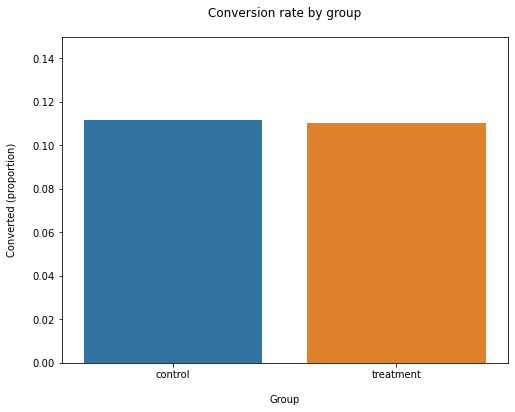

In [13]:
# Plot the like rate by group on a bar plot
plt.figure(figsize=(8,6))
sns.barplot(x=ab_test['group'], y=ab_test['liked'], ci=False)
plt.ylim(0, 0.15)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

### Testing for Stat Sig

In [14]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

# Get the like count for both control and treatment groups
control_results = ab_test[ab_test['group'] == 'control']['liked']
treatment_results = ab_test[ab_test['group'] == 'treatment']['liked']

# Get the number of samples in both groups
count_con = control_results.count()
count_treat = treatment_results.count()

# Sum up the number of successes (likes) in both groups
successes = [control_results.sum(), treatment_results.sum()]
nobs = [count_con, count_treat]

print(count_con)
print(count_treat)
print(successes)
print(nobs)

1199
1199
[134, 132]
[1199, 1199]


In [15]:
# Find the z statistic and p value for proportions based on normal ztest
z_stat, pval = proportions_ztest(successes, nobs=nobs)

# Find the confidence intervals for each test group
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

In [16]:
# print z statistic
print(f'z statistic: {z_stat:.2f}')
# print p-value
print(f'p-value: {pval:.3f}')
# print ci 95% for control group
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
# print ci 95% for treatment group
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 0.13
p-value: 0.897
ci 95% for control group: [0.094, 0.130]
ci 95% for treatment group: [0.092, 0.128]


### Were the results signficant? 

In [17]:
print("The results were not significant, the P value is way higher than our α = 0.05 threshold \nThis means results are not conclusive and we do not reject the null hypothesis")

The results were not significant, the P value is way higher than our α = 0.05 threshold 
This means results are not conclusive and we do not reject the null hypothesis


### What would you advise the engineering team to do moving forward?

In [18]:
print("I would advise the engineering team to keep the old feature as there is no tangible benefit \nfrom the newer treatment")

I would advise the engineering team to keep the old feature as there is no tangible benefit 
from the newer treatment
